In [8]:
from elasticsearch import Elasticsearch
client = Elasticsearch("http://localhost:9200/", api_key="a1VxLUZaWUJ6Q1VRYXlSWTJSX2U6RWx3X0xQbXZURnlsNGU5UmNFeWZhZw==") # localhost

In [9]:
index_name = "summary"

In [3]:
if not client.indices.exists(index=index_name):
    client.indices.create(index=index_name)

In [ ]:
# # Delete
# if client.indices.exists(index=index_name):
#     client.indices.delete(index=index_name)

---

In [10]:
from elasticsearch.helpers import scan

index_base = "arxiv"


def fetch_all_data():
    for hit in scan(
        client,
        index=index_base,
        query={
            "query": {
                "prefix": {
                    "categories.category": "cs", # just fetch computer science for this test
                },
            },
        }):
        yield hit["_source"]

In [5]:
# paper = next(fetch_all_data())
# paper['title'], paper['categories'] 

In [6]:
import ollama
from rolling.embedding import GTEEmbeddingModel
model = GTEEmbeddingModel()

In [7]:
failed = []

In [8]:
import json
import pydantic

class Summary(pydantic.BaseModel):
    contributions: list[str]
    problems_or_goals: list[str]

def summarize(paper):
    template = "Given the following abstract of a scientific paper, summarize their stands:\n"

    try:
        prompt = f'{template}\n{paper["title"]}:\n{paper["abstract"]}'
        response = ollama.generate(model="gemma3:latest", prompt=prompt, format=Summary.model_json_schema())
        response = Summary.model_validate_json(response['response'])
        return response
    except Exception as e:
        global failed
        failed.append(paper)
        print(e)
        return None

In [9]:
def complete_summary(paper, summary: Summary):
    try:
        summary = {
            "contributions": summary.contributions,
            "problems_or_goals": summary.problems_or_goals,
        }
        embedding_data = {
            "title": paper["title"],
        }
        embedding_data.update(summary)
        embedding_data = json.dumps(embedding_data)
        embedding = model.encode(embedding_data)[0]

        source = {
            "embedding": embedding,
            "summary": summary,
        }
        return source
    except Exception as e:
        global failed
        failed.append(paper)
        print(e)
        return None

In [10]:
# summary = summarize(paper)
# complete_summary(paper, summary)

In [11]:
def provide_all():
    for i, paper in enumerate(fetch_all_data()):
        if i % 10000 == 0:
            print(f"Processing {i}...")

        summary = summarize(paper)
        if summary is None:
            continue  # error

        source = complete_summary(paper, summary)
        if source is None:
            continue  # error

        yield {
            "_index": index_name,
            "_id": paper["id"],
            "_source": source,
        }

In [12]:
len(failed)

0

In [ ]:
from elasticsearch import helpers
from elasticsearch.helpers import BulkIndexError

try:
    provider = provide_all()
    helpers.bulk(client, provider, chunk_size=10)
except BulkIndexError as e:
    print("Bulk indexing failed with the following errors:")
    for error in e.errors:
        print(error)


In [14]:
len(failed)

0

---
# check to see how different the embeddings actually are

In [4]:
def fetch_summaries():
    for hit in scan(
        client,
        index=index_name,
        query={
            "query": {
                "match_all": {},
            },
        },
    ):
        yield hit


def fetch_paper(id):
    return client.get(
        index=index_base,
        id=id,
    )

In [11]:
embeddings = []
for summary in fetch_summaries():
    paper = fetch_paper(summary["_id"])
    emb1 = summary['_source']['embedding']
    emb2 = paper['_source']['embedding']
    embeddings.append((emb1, emb2))

In [12]:
len(embeddings)

540

In [13]:
from rolling.embedding import get_similarity
similarities = [
    get_similarity(emb1, emb2)
    for emb1, emb2 in embeddings
]

import numpy as np
similarities = np.array(similarities)

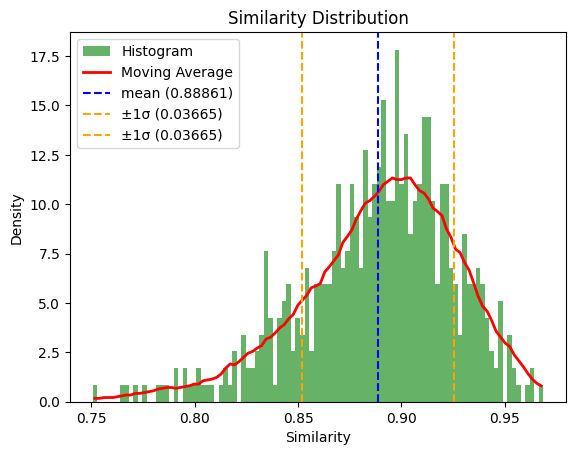

In [21]:
import numpy as np
import matplotlib.pyplot as plt

mean = np.mean(similarities)
std_dev = np.std(similarities)

count, bins, _ = plt.hist(similarities, bins=100, density=True, alpha=0.6, color='g', label='Histogram')

window_size = 20
moving_avg = np.convolve(count, np.ones(window_size)/window_size, mode='same')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.plot(bin_centers, moving_avg, color='r', label='Moving Average', linewidth=2)

plt.axvline(x=mean, color='b', linestyle='--', label=f'mean ({mean:.5f})')
plt.axvline(x=mean - std_dev, color='orange', linestyle='--', label=f'±1σ ({std_dev:.5f})')
plt.axvline(x=mean + std_dev, color='orange', linestyle='--', label=f'±1σ ({std_dev:.5f})')

plt.xlabel('Similarity')
plt.ylabel('Density')
plt.title('Similarity Distribution')
plt.legend()
plt.show()